Notebook from kaggle from Ayushman Buragohain

In [1]:
import sys
sys.path.append('../input/timmmodels/pytorch-image-models')

!git clone https://github.com/benihime91/leaf-disease-classification-kaggle.git
!wandb login a74f67fd5fae293e301ea8b6710ee0241f595a63

Cloning into 'leaf-disease-classification-kaggle'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 873 (delta 58), reused 65 (delta 28), pack-reused 776
Receiving objects: 100% (873/873), 14.89 MiB | 14.82 MiB/s, done.
Resolving deltas: 100% (526/526), done.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## skresnext50_32x4d + MixUp + Label-Smoothing + AdamW + One-Cycle

In [2]:
import os
import wandb
import albumentations as A
import timm
from fastai.vision.all import *
from fastai.callback.wandb import *
from cassava_utils import *

In [3]:
SEED        = 42
IDX         = generate_random_id()
OOF_FOLD    = 0
NUM_CLASSES = 5
CSV_PATH    = 'leaf-disease-classification-kaggle/data/fold_df.csv'
IMAGE_DIR   = '/kaggle/input/cassava-leaf-disease-classification/train_images/'
INPUT_DIMS  = 224
MODEL       = 'resnext50_32x4d'
PROJECT     = 'kaggle-leaf-disease-fastai-runs'
SAVE_NAME   = f"{MODEL}-fold={OOF_FOLD}-{IDX}"

set_seed(SEED, reproducible=True)

run = wandb.init(project=PROJECT)

wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)


In [4]:
data = get_dataset(CSV_PATH, IMAGE_DIR, OOF_FOLD, shuffle=True)
data.head()

,image_id,label,filePath,kfold,is_valid
0,1587173996.jpg,Healthy,/kaggle/input/cassava-leaf-disease-classification/train_images/1587173996.jpg,2,False
1,404115232.jpg,Cassava Mosaic Disease (CMD),/kaggle/input/cassava-leaf-disease-classification/train_images/404115232.jpg,0,True
2,3945098769.jpg,Cassava Mosaic Disease (CMD),/kaggle/input/cassava-leaf-disease-classification/train_images/3945098769.jpg,1,False
3,4037735151.jpg,Cassava Mosaic Disease (CMD),/kaggle/input/cassava-leaf-disease-classification/train_images/4037735151.jpg,3,False
4,730805822.jpg,Cassava Mosaic Disease (CMD),/kaggle/input/cassava-leaf-disease-classification/train_images/730805822.jpg,1,False


In [5]:
TRAIN_AUGS = A.Compose([
    A.OneOf([A.RandomResizedCrop(INPUT_DIMS, INPUT_DIMS), A.CenterCrop(INPUT_DIMS, INPUT_DIMS)], p=0.5),
    A.Resize(INPUT_DIMS, INPUT_DIMS, p=1.0),
    A.HorizontalFlip(),
    A.OneOf([A.Flip(), A.ShiftScaleRotate()], p=0.5),
    A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
    A.OneOf([A.CLAHE(), A.HueSaturationValue(0.2, 0.2, 0.2)], p=0.5),
    A.CoarseDropout(p=0.5),
])

VALID_AUGS = A.Compose([A.Resize(INPUT_DIMS, INPUT_DIMS, p=1.0)])

ITEM_TFMS  = AlbumentationsTransform(TRAIN_AUGS, VALID_AUGS)
BATCH_TFMS = [Normalize.from_stats(*imagenet_stats)]

cassava = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  splitter=ColSplitter(),
                  get_x=lambda o: o['filePath'], 
                  get_y=lambda o: o['label'], 
                  item_tfms=ITEM_TFMS, 
                  batch_tfms=BATCH_TFMS)

dls = cassava.dataloaders(data, bs=64, num_workers=4)

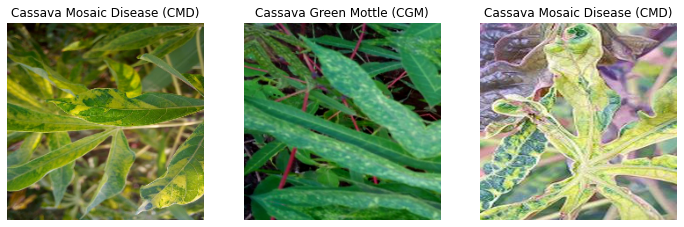

In [6]:
dls.train.show_batch(max_n=3,figsize=(12,6))

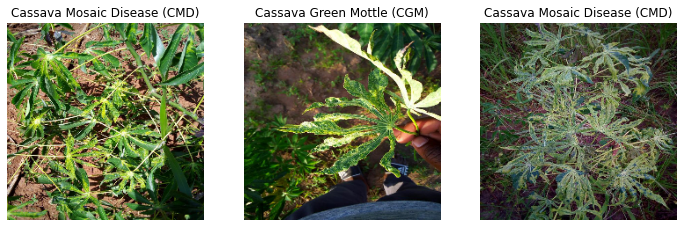

In [7]:
dls.valid.show_batch(max_n=3,figsize=(12,6))

In [8]:
encoder = timm.create_model(MODEL, pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50_32x4d_ra-d733960d.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_ra-d733960d.pth


In [9]:
callbacks = [SaveModelCallback(monitor='accuracy'), WandbCallback(log_preds=False, log_model=False), 
             GradientAccumulation(2*dls.bs)]

learn = timm_learner(dls=dls, encoder=encoder, cut=-2, init=True,
                    state=None, modifiers=None, act=nn.ReLU(inplace=True),              
                    loss_func=LabelSmoothingCrossEntropy(), opt_func=Adam, 
                    splitter=custom_splitter, metrics=[accuracy],
                    cbs=callbacks).to_native_fp16()

In [10]:
learn.model

TransferLearningModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.6309573650360107)

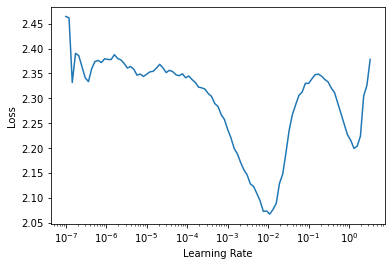

In [11]:
learn.freeze()
learn.lr_find()

In [12]:
learn.fit_one_cycle(2, slice(2e-03), wd=0.1, cbs=[MixUp(0.5)])

epoch,train_loss,valid_loss,accuracy,time
0,1.287623,1.011804,0.699533,03:51
1,1.164436,0.983022,0.714252,03:45


Better model found at epoch 0 with accuracy value: 0.699532687664032.
Better model found at epoch 1 with accuracy value: 0.7142523527145386.


In [13]:
learn.save('stage-1')

Path('models/stage-1.pth')

SuggestedLRs(lr_min=1.4454397387453355e-06, lr_steep=1.0964781722577754e-06)

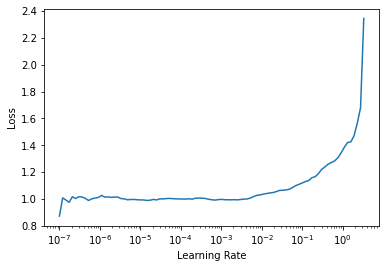

In [14]:
learn = learn.load('stage-1')

learn.unfreeze()
learn.lr_find()

In [15]:
learn.fit_one_cycle(15, slice(5e-04), wd=0.1, cbs=[MixUp()], pct_start=0.3, div=5.0)

epoch,train_loss,valid_loss,accuracy,time
0,1.102720,0.933525,0.745093,03:52
1,1.074429,0.892597,0.757477,03:56
2,1.041844,0.842242,0.787150,04:01
3,0.981924,0.793868,0.809112,04:02
4,0.948283,0.768680,0.822897,04:00
5,0.936706,0.750969,0.829907,04:00
6,0.891855,0.736922,0.837383,04:03
7,0.896291,0.722822,0.846729,03:58
8,0.891028,0.721932,0.846262,03:59
9,0.866046,0.716123,0.846495,03:57


Better model found at epoch 0 with accuracy value: 0.7450934648513794.
Better model found at epoch 1 with accuracy value: 0.7574766278266907.
Better model found at epoch 2 with accuracy value: 0.7871495485305786.
Better model found at epoch 3 with accuracy value: 0.8091121315956116.
Better model found at epoch 4 with accuracy value: 0.82289719581604.
Better model found at epoch 5 with accuracy value: 0.8299065232276917.
Better model found at epoch 6 with accuracy value: 0.8373831510543823.
Better model found at epoch 7 with accuracy value: 0.8467289805412292.
Better model found at epoch 10 with accuracy value: 0.85677570104599.
Better model found at epoch 11 with accuracy value: 0.8574766516685486.


In [16]:
learn.save('stage-2')

Path('models/stage-2.pth')

In [17]:
learn = learn.load('stage-2')
learn = learn.to_native_fp32()

save_dir = f"{SAVE_NAME}.pt"
torch.save(learn.model.state_dict(), save_dir)

In [18]:
wandb.save(os.path.abspath(save_dir))
wandb.finish()

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


epoch,17
train_loss,0.85183
raw_loss,0.977
wd_0,0.1
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.1
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▆▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▄▄▅▃▃▃▃▃▂▃▃▃▃▃▂▂▂▂▃▂▂▂▂▁▂▂▂▂▁▃▃▁▃▁▂▁▁▂▂
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▄█▇▃▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
mom_0,▅▁▂▆███▇▆▆▄▃▂▁▁▁▁▁▁▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▄█▇▃▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
